In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
# from qiskit.visualization import array_to_latex  # 转换为LaTeX格式（ket形式）
from pennylane import math
import torch.nn as nn
import torch
import torch.nn.functional as F

In [2]:
#加载处理好的数据集
def load_processed_mnist():
    try:
        data = np.load('./data/mnist_0_1_binary.npz')
        x_train = data['x_train']
        y_train = data['y_train']
        x_test = data['x_test']
        y_test = data['y_test']
        
        print(f"加载成功:")
        print(f"训练集: 样本数={len(x_train)}, 标签数={len(y_train)}")
        print(f"测试集: 样本数={len(x_test)}, 标签数={len(y_test)}")
        
        return x_train, y_train, x_test, y_test
    except FileNotFoundError:
        print("错误: 找不到处理后的数据集文件。请先运行数据处理脚本。")
        return None, None, None, None

In [3]:
x_train, y_train, x_test, y_test = load_processed_mnist()

加载成功:
训练集: 样本数=12665, 标签数=12665
测试集: 样本数=2115, 标签数=2115


In [4]:
# 处理数据集
x_train = x_train[:800]
y_train = y_train[:800]
x_test = x_test[:200]
y_test = y_test[:200]
# 数据一维化 4*4 → 16
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)
print(x_train.shape,x_test.shape)

(800, 16) (200, 16)


In [5]:
n_qubits = 4
dev = qml.device('default.qubit',wires=n_qubits)

In [6]:
def encoder(features):
    #批处理
    batched = math.ndim(features) > 1
    features = math.T(features) if batched else features
    for i in range(n_qubits):
        qml.Hadamard(wires=i)
    for i in range(16):
        x = bin(i)[2:].zfill(4) #4位二进制位置
        qml.Barrier()
        for j in range(3,-1,-1):
            if x[j] == '0':
                qml.X(3-j)
        qml.ctrl(qml.PhaseShift,range(3),'111')(features[i]*np.pi,wires=3)
        for j in range(3,-1,-1):
            if x[j] == '0':
                qml.X(3-j)
        # qml.Barrier()
    # return qml.state()

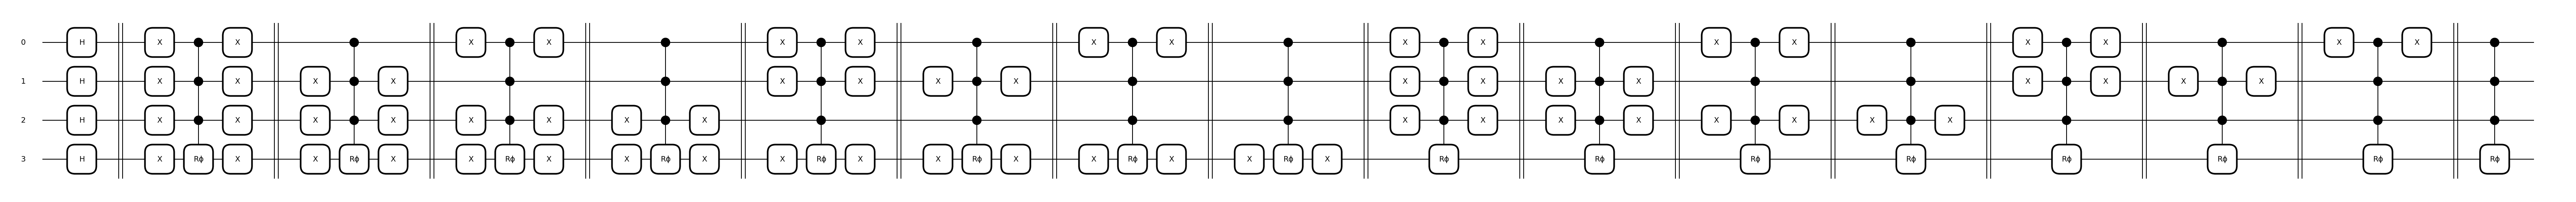

In [7]:
qml.draw_mpl(encoder)(x_train[0].flatten())
plt.show()

In [8]:
# data = np.array([0,0,0,0,
#                 0,0,1,0,
#                 0,0,0,0,
#                 0,0,0,0])
# circuit = qml.QNode(encoder, dev)
# result = circuit(data)
# print(result)
# # 方法2：LaTeX格式（标准ket形式，适合显示）
# latex_ket = array_to_latex(result, prefix="|\\psi\\rangle = ",max_size=16)
# print("\nLaTeX ket形式：")
# display(latex_ket)  # 输出：|ψ⟩ = 0.707|00⟩ + 0.707|11⟩（类似格式）

In [9]:
def ansatz(weights):
    interface = math.get_interface(weights)
    weights = math.asarray(weights, like=interface)
    shape = math.shape(weights)
    if not (len(shape) == 3 or len(shape) == 2):  # 3 is when batching, 2 is no batching
        raise ValueError(
            f"Weights tensor must be 2-dimensional "
            f"or 3-dimensional if batching; got shape {shape}"
        )

    if shape[-1] != n_qubits:
        # index with -1 since we may or may not have batching in first dimension
        raise ValueError(
            f"Weights tensor must have last dimension of length {n_qubits}; got {shape[-1]}"
        )
    repeat = math.shape(weights)[-2]-1
    for rep in range(repeat):
        for i in range(n_qubits):
            qml.RY(weights[rep,i],i)
        for i in range(n_qubits-1):
            qml.CNOT(wires=[i,i+1])
        qml.Barrier()
    for i in range(n_qubits):
        qml.RX(weights[repeat,i],i)

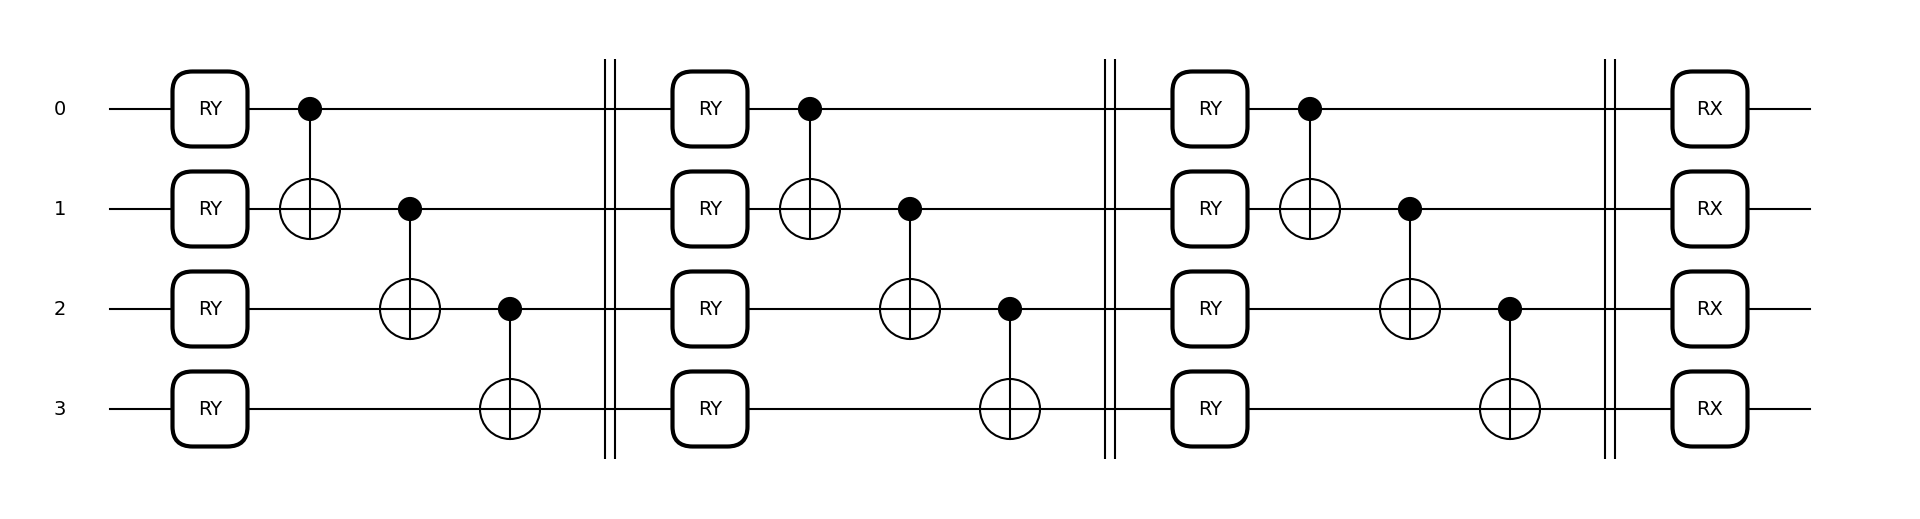

In [10]:
qml.draw_mpl(ansatz)(np.random.rand(4,4))
plt.show()

In [11]:
@qml.qnode(dev,interface="torch")
def qnode(inputs,weights):
    # print(inputs.shape)#torch.Size([25, 16])
    # 验证输入维度：必须是 (batch, 10)，否则报错
    assert inputs.shape[-1] == 16, f"qlayer需要16维输入，实际输入{inputs.shape[-1]}维"
    encoder(inputs)
    ansatz(weights)
    return [qml.expval(qml.Z(i)) for i in [2,3]]

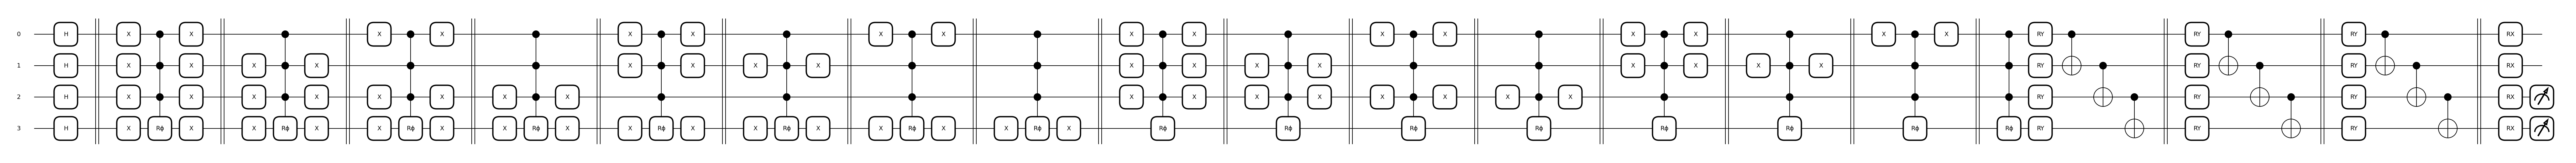

In [12]:
qml.draw_mpl(qnode,level=2)(np.random.rand(16), np.random.rand(4, 4))
plt.show()

In [13]:
weight_shapes = {"weights":(4,4)}
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes) 

## 构建量子神经网络

In [14]:
model = nn.Sequential(qlayer)

## 模型训练

In [15]:
def accuracy(y_pred, y_true):
    predictions = torch.argmax(y_pred, axis=1).detach().numpy()
    correct = (predictions == y_true).sum().item()
    
    return correct / len(y_true)

In [16]:
opt = torch.optim.Adam(model.parameters(), lr=0.01)
loss = torch.nn.CrossEntropyLoss()

In [17]:
x_train = torch.tensor(x_train, requires_grad=True).float()
x_test = torch.tensor(x_test, requires_grad=True).float()

In [18]:
batch_size = 25
batches = x_train.shape[0] // batch_size

data_loader = torch.utils.data.DataLoader(
    list(zip(x_train, y_train)), batch_size=25, shuffle=True, drop_last=True
)

epochs = 20
accuracies = []
loss_list = []


In [19]:

for epoch in range(epochs):

    running_loss = 0
    sum_acc = 0
    for xs, ys in data_loader:
        opt.zero_grad()
        # 前向传播，计算损失
        y_pred = model(xs)
        loss_evaluated = loss(y_pred, ys)
        loss_evaluated.backward()
        acc = accuracy(y_pred, ys)
        opt.step()
        running_loss += loss_evaluated
        sum_acc += acc
    accuracies.append(sum_acc / batches)
    avg_loss = running_loss / batches
    loss_list.append(avg_loss.detach().numpy())
    print("Average loss over epoch {}: {:.4f}".format(epoch + 1, avg_loss))
    print("Average accuracy over epoch {}: {:.2f}%".format(epoch + 1, sum_acc / batches * 100))


Average loss over epoch 1: 0.7444
Average accuracy over epoch 1: 41.75%
Average loss over epoch 2: 0.6034
Average accuracy over epoch 2: 74.62%
Average loss over epoch 3: 0.4973
Average accuracy over epoch 3: 85.25%
Average loss over epoch 4: 0.4238
Average accuracy over epoch 4: 92.13%
Average loss over epoch 5: 0.3965
Average accuracy over epoch 5: 93.38%
Average loss over epoch 6: 0.3855
Average accuracy over epoch 6: 92.50%
Average loss over epoch 7: 0.3806
Average accuracy over epoch 7: 93.38%
Average loss over epoch 8: 0.3768
Average accuracy over epoch 8: 93.50%
Average loss over epoch 9: 0.3745
Average accuracy over epoch 9: 93.00%
Average loss over epoch 10: 0.3728
Average accuracy over epoch 10: 92.75%
Average loss over epoch 11: 0.3709
Average accuracy over epoch 11: 92.63%
Average loss over epoch 12: 0.3692
Average accuracy over epoch 12: 93.00%
Average loss over epoch 13: 0.3673
Average accuracy over epoch 13: 93.50%
Average loss over epoch 14: 0.3654
Average accuracy over

In [20]:
y_pred = model(x_test)
predictions = torch.argmax(y_pred, axis=1).detach().numpy()
# print(f"预测前10个测试集标签: {predictions[:10]}")
correct = [1 if p == p_true else 0 for p, p_true in zip(predictions, y_test)]
accuracy = sum(correct) / len(correct)
print(f"Accuracy: {accuracy * 100}%")

Accuracy: 97.0%


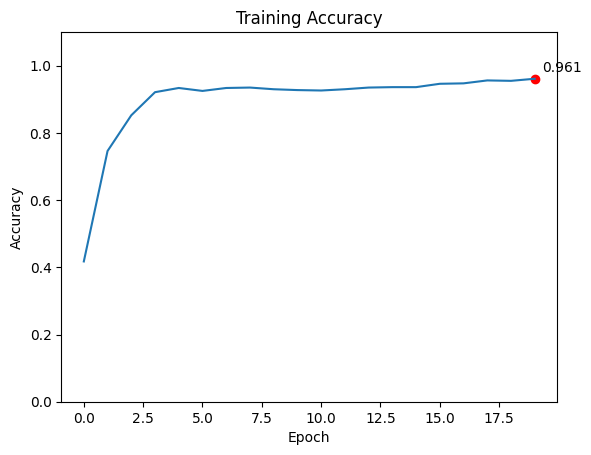

In [21]:
plt.plot(range(epochs),accuracies)

max_idx = np.argmax(accuracies)
max_acc = accuracies[max_idx]
plt.scatter(max_idx,max_acc,color='red')
plt.annotate(f'{max_acc:.3f}',(max_idx,max_acc),xytext=(5,5),textcoords='offset points')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.ylim(0,1.1)
plt.show()

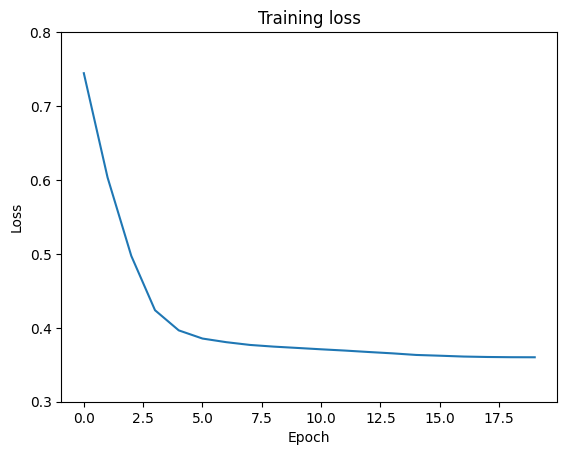

In [25]:
plt.plot(range(epochs),loss_list)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.ylim(0.30,0.8)
plt.show()